# Variational Inference for Neural Networks: example of a cubic function.

The network architecture is fixed (benchmark) to one hidden layer with 100 units (total of 301 weights). In this example, the prior is assumed known as standard gaussian.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from UQ_in_ML.general_utils import *
from UQ_in_ML.epistemic_regressors import (
    Regressor, BayesByBackprop, alphaBB, ModelAveragingLOO, ModelAveragingLOOalphaBB)
from UQ_in_ML.epistemic_regressors_mcmc import MCMCRegressor

### Some plotting functions

In [35]:
fontsize = 15
ylim = (-2, 2); xlim = (-1., 1.)
set_axis_limits = lambda x: (x.set_ylim(ylim) and x.set_xlim(xlim))
set_labels = lambda x: (x.set_xlabel(r'input $X$', fontsize=fontsize) and x.set_ylabel(
    r'output $y$', fontsize=fontsize))
set_yticks = lambda x: x.set_yticks([-2., -1., 0, 1., 2.])
set_xticks = lambda x: x.set_xticks([-1., -0.5, 0., 0.5, 1.])
set_stuff = lambda x: (set_labels(x) and set_axis_limits(x) and set_yticks(x) and set_xticks(x) 
                       and plt.xticks(fontsize=13) and plt.yticks(fontsize=13))
kwargs_data = {'color': 'blue', 'linestyle': 'none', 'marker': 'x', 'markersize': 9, 'label': 'training data'}
colors_layers = ['green', 'blue', 'red', 'orange']
markers_layers = ['o', '+', 'x', 'd', 's', '+']
# look at uncertainty in terms of std. dev. or 95% interval?
# stat_to_plot = 'std'   # 'std' or 'perc'

def plot_loss(loss_history):
    n_epochs = len(loss_history)
    fig, ax = plt.subplots(figsize=(10, 2.5), ncols=2)
    ax[0].plot(np.arange(1, n_epochs+1), loss_history)
    ax[0].set_xlabel('epochs 1 to last'); ax[0].set_ylabel('loss')
    ax[1].plot(np.arange(n_epochs//2+1, n_epochs+1), loss_history[n_epochs//2:])
    ax[1].set_xlabel('epochs {} to last'.format(n_epochs//2)); ax[1].set_ylabel('loss')
    return fig, ax

def plot_convergence_VI(weights_mean, weights_std, weights_to_track):
    fig, ax = plt.subplots(figsize=(13,3.5), ncols=2)
    for l, (means, stds) in enumerate(zip(weights_mean[:-1], weights_std[:-1])):
        for j, (w_mean, w_std) in enumerate(zip(means.T, stds.T)):
            alpha = 0.15+j*0.8/weights_to_track[l]
            ax[0].plot(w_mean, color=colors_layers[l], alpha=alpha)
            ax[1].plot(w_std, color=colors_layers[l], alpha=alpha)
    ax[0].set_xlabel('epochs'); ax[0].set_ylabel(r'$\mu$'); 
    ax[0].set_title(r'Convergence of means $\mu_{i}$')
    ax[1].set_xlabel('epochs'); ax[1].set_ylabel(r'$\sigma$'); 
    ax[1].set_title(r'Convergence of std. devs. $\sigma_{i}$')
    return fig, ax

def plot_VI_mask(VI_mean, VI_std, fig=None, ax=None):
    from scipy.stats import norm
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 3.5), ncols=len(VI_mean))
    for i, (mu, sig) in enumerate(zip(VI_mean, VI_std)):
        for m, s in zip(mu.reshape((-1,)), sig.reshape((-1,))):
            d = norm(loc=m, scale=s)
            md, vd = d.stats(moments='mv')
            xd = np.linspace(md - 3.*np.sqrt(vd), md+3.*np.sqrt(vd), 200)
            ax[i].plot(xd, d.pdf(xd))
    ax[0].set_title(r'$W^{[0]}$', fontsize=20); ax[0].set_xlim([-2.5, 2.5])
    ax[1].set_title(r'$b^{[0]}$', fontsize=20); ax[1].set_xlim([-2.5, 0])
    ax[2].set_title(r'$W^{[1]}$', fontsize=20); ax[2].set_xlim([-3., 3.])
    ax[3].set_title(r'$b^{[1]}$', fontsize=20); ax[3].set_xlim([-0.05, 0.05])
    for i in range(4):
        ax[i].set_xlabel(r'$\omega$', fontsize=16)
        ax[i].set_ylabel(r'$q_{\theta}(\omega)$', fontsize=16)
    return fig, ax

In [13]:
def plot_results_vi(reg, ns=10000, stat_to_plot='perc'):
    plot_loss(reg.loss_history)
    plt.show()
    plot_convergence_VI(reg.variational_mu_history, reg.variational_sigma_history, reg.weights_to_track)
    plt.show()

    VI_mean, VI_std = reg.return_marginals()
    fig, ax = plot_VI_mask(VI_mean=VI_mean, VI_std=VI_std)
    fig.tight_layout()
    plt.show(fig)

    fig, ax = plt.subplots(figsize=(6, 4.))
    if stat_to_plot == 'perc':
        y_mean, y_uq, y_MC = reg.predict_uq(
            X=x_plot, ns=ns, return_std=False, return_percentiles=(2.5, 97.5), return_MC=2, 
            aleatoric_in_std_perc=True, aleatoric_in_MC=False)
    elif stat_to_plot == 'std':
        y_mean, y_uq, y_MC = reg.predict_uq(
            X=x_plot, ns=ns, return_std=True, return_percentiles=(), return_MC=2, 
            aleatoric_in_std_perc=True, aleatoric_in_MC=False)
    plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
    #plot_mean_MC(x_plot, y_MC=y_MC, ax=ax, color_MC='red', label_MC='one posterior draw')
    ax.plot(xn, yn, **kwargs_data)
    ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.17), ncol=2, fancybox=True, shadow=True,
             fontsize=12)
    set_stuff(ax)
    fig.tight_layout()
    plt.show()
    return None

### Set the problem (data) and the network 

AttributeError: 'Figure' object has no attribute 'xticks'

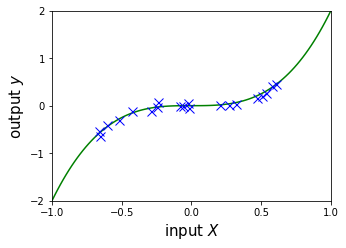

In [34]:
var_n = 0.05 ** 2
f = lambda x, noisy: 2 * x ** 3 + noisy*np.sqrt(var_n)*np.random.normal(size=x.shape)
n_data = 20
xn = np.array([-0.02519606, -0.29152739, -0.60474655, 0.31944225, -0.08100553, -0.24830156, 0.57461577, 
               0.50232181, 0.60433894, -0.02046175, 0.53479088, -0.65367602, -0.06110107, 0.46652892, 
               -0.66163461, 0.26793157, 0.20481661, -0.24144274, -0.42398829, -0.52080597]).reshape((-1, 1))
yn = np.array([0.04928457864952569, -0.11915410490457669, -0.405097551770553, 0.029554098140267056, 
               -0.013086956159543405, -0.017770100521146612, 0.42280077037504055, 0.1944984572601308, 
               0.4534092801344878, -0.05744532400253988, 0.27416952296635494, -0.6450129511010473, 
               -0.00434618253501617, 0.16330603887330705, -0.5274704221475347, 0.02189741180766931, 
               0.012647796994763167, 0.08367359752673682, -0.10875986459325471, 
               -0.2964629150726794]).reshape((-1, 1))
x_plot = np.linspace(-1, 1, 100).reshape((-1,1))
y_plot = f(x_plot, False)

fig, ax = plt.subplots(figsize=(5, 3.5), ncols=1)
ax.plot(x_plot, y_plot, **{'color': 'green', 'linestyle': '-', 'label': 'data generating function'})
ax.plot(xn, yn, color='blue', linestyle='none', marker='x', markersize=9, label='noisy training data')
set_stuff(ax)
ax.grid(True)
ax.set_title('Extrapolation 1D example', fontsize=16)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fancybox=True, shadow=True, fontsize=14)
plt.legend(fontsize=13, loc='lower right')
#plt.savefig('cubic_true_f.pdf', bbox_inches='tight')
plt.show()

In [21]:
nn = {'input_dim': 1, 
      'output_dim': 1,
      'var_n': var_n,
      'hidden_units': (100,),
      'activation': tf.nn.relu,
      'prior_means': 0.,
      'prior_stds': 1.}
weights_to_track = [] # track 5 kernel weights in each uq layer, and no bias
[weights_to_track.extend([5, 0]) for j in range(len(nn['hidden_units']) + 1)]

training_dict = {'epochs': 5000, 'lr': 0.005, 'ns': 20}

# Part 1: BayesByBackprop vs. alpha BB vs. MCMC

6.946392297744751


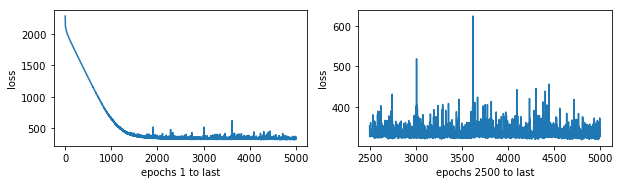

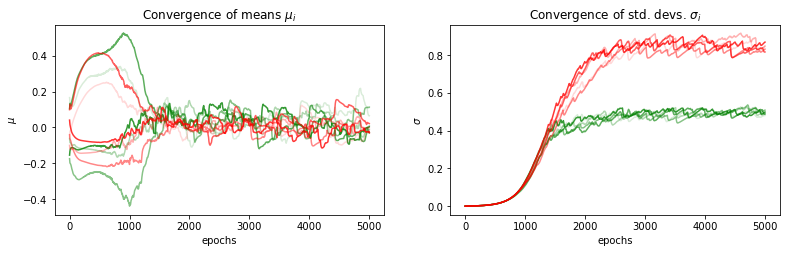

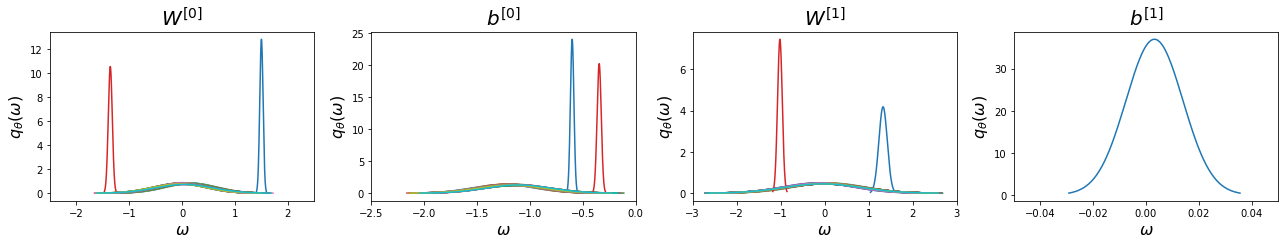

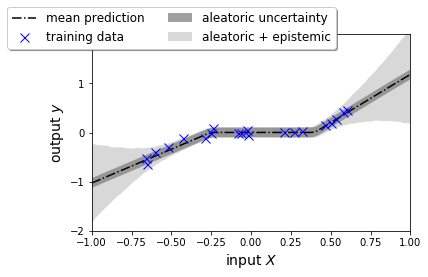

In [83]:
t0 = time.time()
reg_0 = BayesByBackprop(weights_to_track=weights_to_track, analytical_grads=True, **nn)
reg_0.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_0)

10.428040027618408


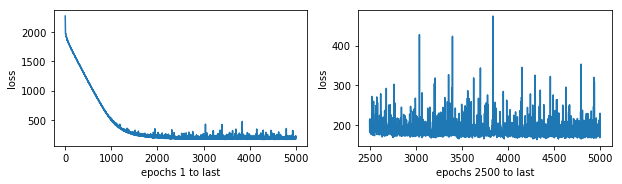

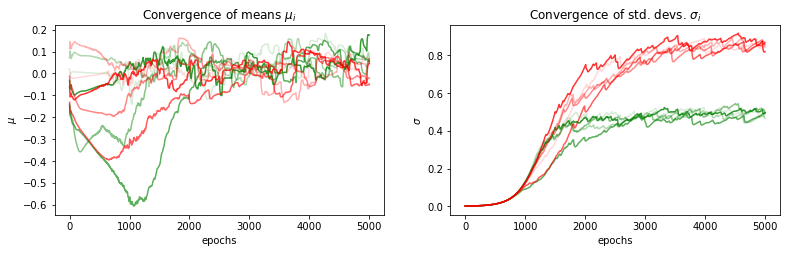

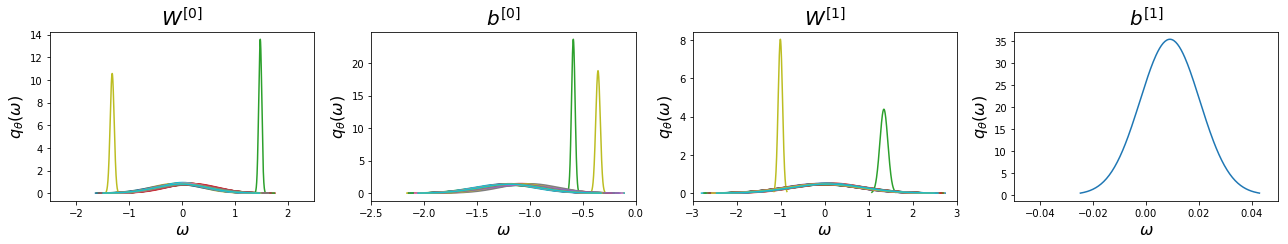

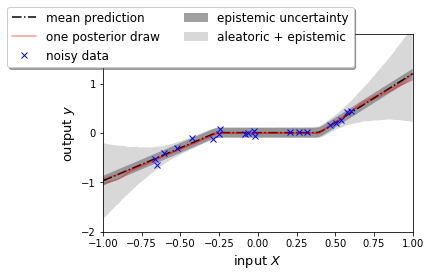

In [7]:
t0 = time.time()
reg_1 = alphaBB(alpha=0.0001, weights_to_track=weights_to_track, **nn)
reg_1.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_1)

30.159791946411133


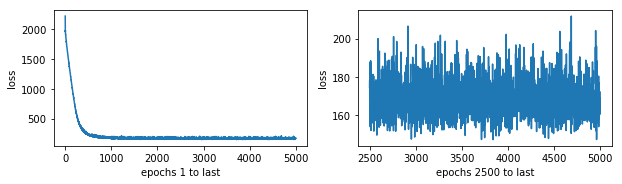

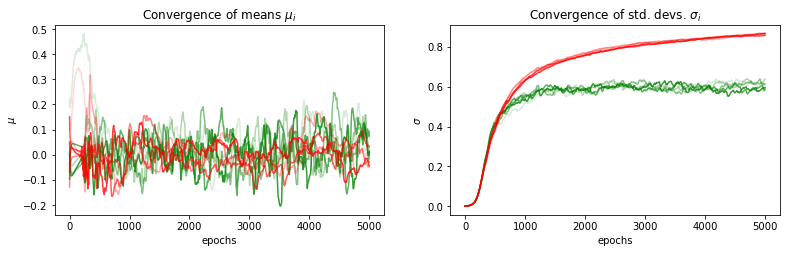

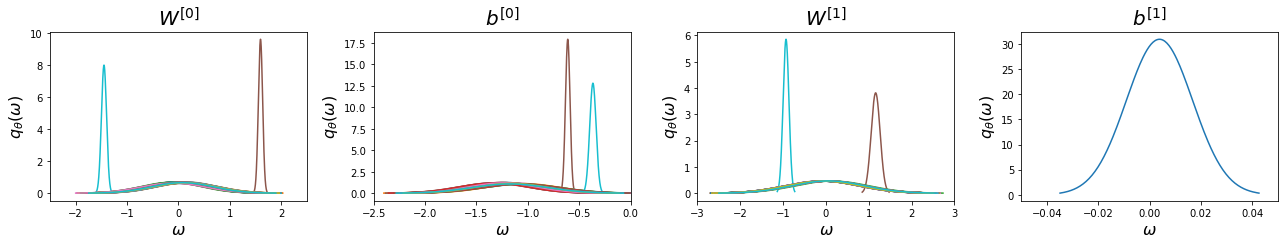

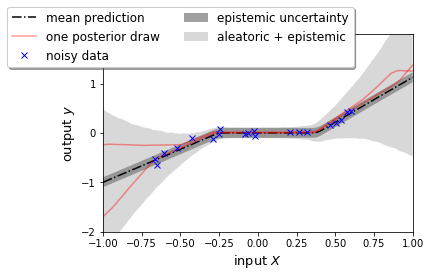

In [8]:
t0 = time.time()
reg_1bis = alphaBB_v2(
    alpha=0.1, nfactors=20, tie_factors=tie_factors_5, weights_to_track=weights_to_track,**nn)
reg_1bis.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_1bis)

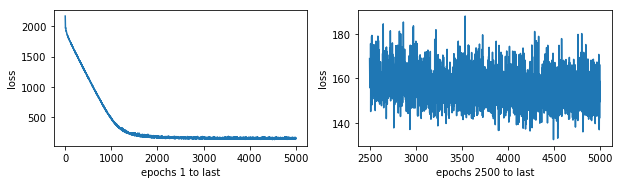

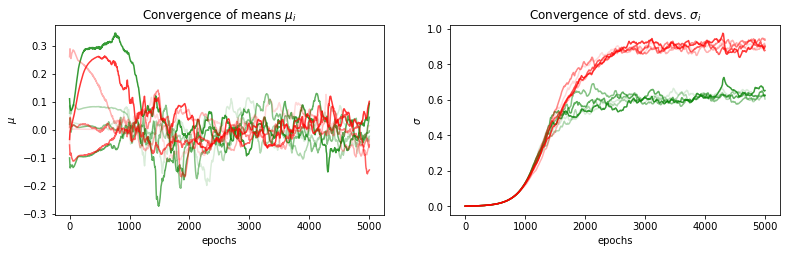

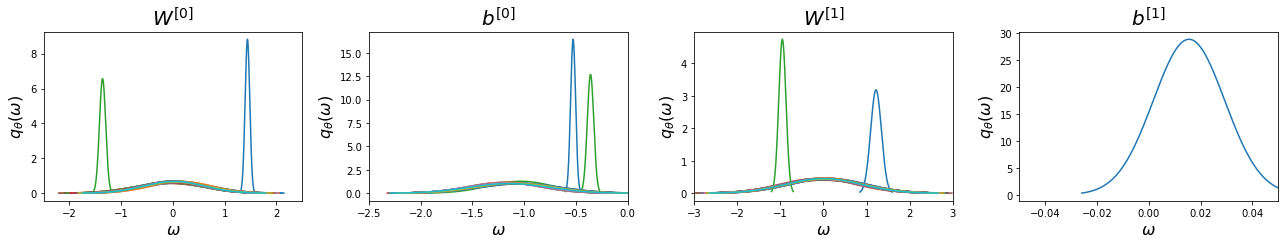

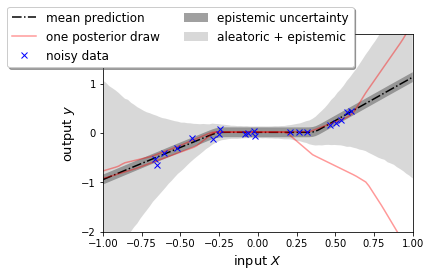

In [9]:
t0 = time.time()
reg_2 = alphaBB(alpha=0.2, weights_to_track=weights_to_track, **nn)
reg_2.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_2)

In [22]:
reg_fig_0 = BayesByBackprop(analytical_grads=True, **nn)
reg_fig_0.fit(X=xn, y=yn, **training_dict)

reg_fig_1 = alphaBB(alpha=0.1, **nn)
reg_fig_1.fit(X=xn, y=yn, **training_dict)

reg_fig_2 = alphaBB(alpha=0.2, **nn)
reg_fig_2.fit(X=xn, y=yn, **training_dict)

regs_figure = [reg_fig_0, reg_fig_1, reg_fig_2]

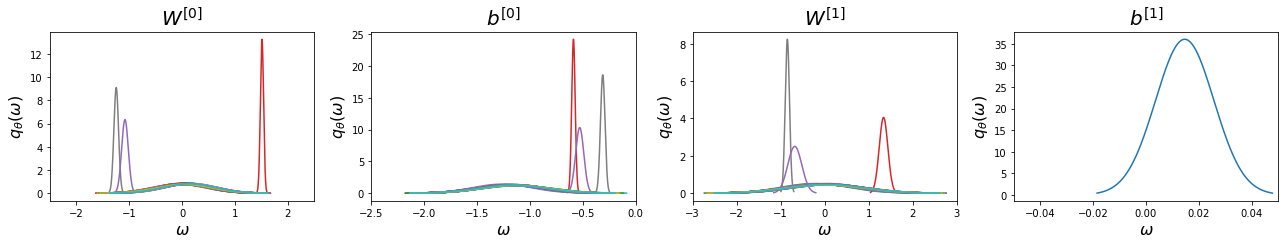

In [23]:
VI_mean, VI_std = reg_fig_0.return_marginals()
fig, ax = plot_VI_mask(VI_mean=VI_mean, VI_std=VI_std)
fig.tight_layout()
#plt.savefig('VI_posterior_cubic.pdf')
plt.show(fig)

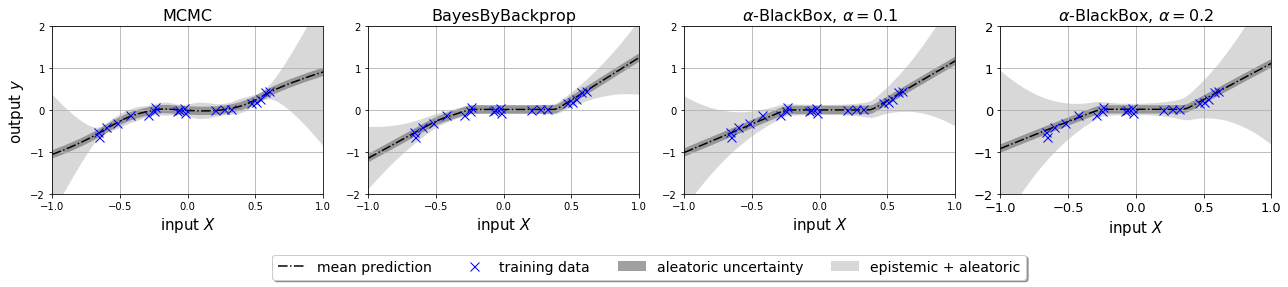

In [24]:
# Actual figure that I will need
stat_to_plot = 'std'   # 'std' or 'perc'
fig, ax = plt.subplots(ncols=4, figsize=(18, 3.5))
dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
if stat_to_plot == 'std':
    dict_predict.update({'return_std': True, 'return_percentiles': ()})
# MCMC
for i in range(4):
    if i == 0:
        import pickle
        folder = '/Users/audreyolivier/Data/UQ_in_ML_MCMC_runs/'
        with open(folder+'cubic_March20_0_bis.pkl', 'rb') as f:
            mcmc_dict = pickle.load(f)
        reg = MCMCRegressor(algorithm=mcmc_dict['algorithm'], jump=mcmc_dict['jump'], nburn=mcmc_dict['nburn'], 
            **mcmc_dict['nn'])
        reg.fit(X=xn, y=yn, nsamples_per_chain=0)
        reg.mcmc_sampler.samples = mcmc_dict['samples'][-5:, :, :].reshape((-1, reg.dimension))
        title = 'MCMC'
        y_mean, y_uq = reg.predict_uq(X=x_plot, **dict_predict)
        plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
        ax[i].plot(xn, yn, **kwargs_data)
    else:
        dict_predict['ns']=10000
        if i == 1:
            reg = regs_figure[0]
            title = 'BayesByBackprop'
        elif i == 2:
            reg = regs_figure[1]
            title = r'$\alpha$-BlackBox, $\alpha=0.1$'
        elif i == 3:
            reg = regs_figure[2]
            title = r'$\alpha$-BlackBox, $\alpha=0.2$'
        y_mean, y_uq = reg.predict_uq(X=x_plot, **dict_predict)
        plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
        ax[i].plot(xn, yn, **kwargs_data)
    set_stuff(ax[i])
    if i > 0:
        ax[i].set_ylabel('')
    ax[i].set_xticks([-1, -0.5, 0, 0.5, 1])
    ax[i].grid(True)
    ax[i].set_title(title, fontsize=16)
fig.legend(
    (ax[0].lines[0], ax[0].lines[1], ax[0].patches[0], ax[0].patches[1]),
    ('mean prediction', 'training data', 'aleatoric uncertainty', 'epistemic + aleatoric'),
    ncol=4, fancybox=True, shadow=True, fontsize=14,
    bbox_to_anchor=(0.8, 0), bbox_transform=plt.gcf().transFigure)
fig.tight_layout()
#plt.savefig('various_algos_cubic.pdf')
plt.show()

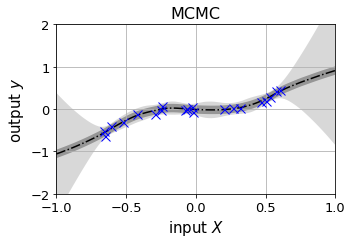

In [28]:
# MCMC alone
stat_to_plot = 'std'   # 'std' or 'perc'
fig, ax = plt.subplots(figsize=(5, 3.5))
dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
if stat_to_plot == 'std':
    dict_predict.update({'return_std': True, 'return_percentiles': ()})
# MCMC
import pickle
folder = '/Users/audreyolivier/Data/UQ_in_ML_MCMC_runs/'
with open(folder+'cubic_March20_0_bis.pkl', 'rb') as f:
    mcmc_dict = pickle.load(f)
reg = MCMCRegressor(algorithm=mcmc_dict['algorithm'], jump=mcmc_dict['jump'], nburn=mcmc_dict['nburn'], 
    **mcmc_dict['nn'])
reg.fit(X=xn, y=yn, nsamples_per_chain=0)
reg.mcmc_sampler.samples = mcmc_dict['samples'][-5:, :, :].reshape((-1, reg.dimension))
title = 'MCMC'
y_mean, y_uq = reg.predict_uq(X=x_plot, **dict_predict)
plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
ax.plot(xn, yn, **kwargs_data)
set_stuff(ax)
ax.grid(True)
ax.set_title(title, fontsize=16)
#fig.legend(
#    (ax.lines[0], ax.lines[1], ax.patches[0], ax.patches[1]),
#    ('mean prediction', 'training data', 'aleatoric uncertainty', 'epistemic + aleatoric'),
#    ncol=4, fancybox=True, shadow=True, fontsize=14,
#    bbox_to_anchor=(0.8, 0), bbox_transform=plt.gcf().transFigure)
fig.tight_layout()
plt.savefig('cubic_mcmc.pdf', bbox_inches='tight')
plt.show()

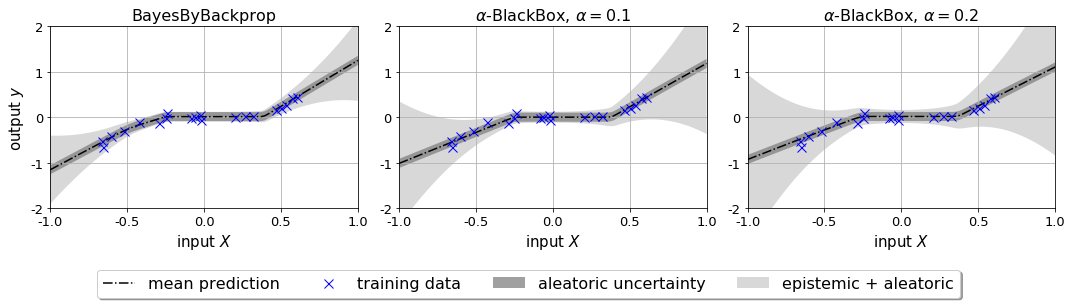

In [50]:
# The others
stat_to_plot = 'std'   # 'std' or 'perc'
dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
if stat_to_plot == 'std':
    dict_predict.update({'return_std': True, 'return_percentiles': ()})

fig, ax = plt.subplots(ncols=3, figsize=(15, 3.7))
# MCMC
for i in range(3):
    dict_predict['ns']=10000
    if i == 0:
        reg = regs_figure[0]
        title = 'BayesByBackprop'
    elif i == 1:
        reg = regs_figure[1]
        title = r'$\alpha$-BlackBox, $\alpha=0.1$'
    elif i == 2:
        reg = regs_figure[2]
        title = r'$\alpha$-BlackBox, $\alpha=0.2$'
    y_mean, y_uq = reg.predict_uq(X=x_plot, **dict_predict)
    plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
    ax[i].plot(xn, yn, **kwargs_data)
    set_stuff(ax[i])
    if i > 0:
        ax[i].set_ylabel('')
    ax[i].set_yticklabels([-2, -1, 0, 1, 2], fontsize=13)
    ax[i].set_xticklabels([-1.0, -0.5, 0., 0.5, 1.0], fontsize=13)
    ax[i].grid(True)
    ax[i].set_title(title, fontsize=16)
fig.legend(
    (ax[0].lines[0], ax[0].lines[1], ax[0].patches[0], ax[0].patches[1]),
    ('mean prediction', 'training data', 'aleatoric uncertainty', 'epistemic + aleatoric'),
    ncol=4, fancybox=True, shadow=True, fontsize=16,
    bbox_to_anchor=(0.9, 0), bbox_transform=plt.gcf().transFigure)
fig.tight_layout()
plt.savefig('cubic_3algos.pdf', bbox_inches='tight')
plt.show()

# Part 2: Look at alpha Black-Box and model comparisons

First show principle: train one model on two LOO sets.

In [39]:
ind_i = [2, 19, 11]
xn_train = np.array([xn[j] for j in range(xn.shape[0]) if j not in ind_i])
yn_train = np.array([yn[j] for j in range(xn.shape[0]) if j not in ind_i])
xn_leave = np.array([xn[j] for j in range(xn.shape[0]) if j in ind_i])
yn_leave = np.array([yn[j] for j in range(xn.shape[0]) if j in ind_i])

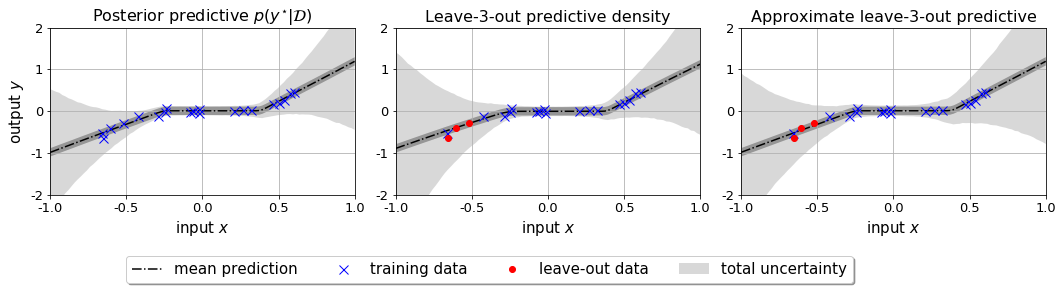

In [40]:
fig, ax = plt.subplots(figsize=(15, 3.5), ncols=3)
reg = alphaBB(alpha=0.1, random_seed=4567, **nn)
reg.fit(X=xn, y=yn, **training_dict)
for i in [0, 2, 1]:
    if i == 0:
        y_mean, y_perc = reg.predict_uq(
            X=x_plot, ns=10000, return_std=False, return_percentiles=(2.5, 97.5), return_MC=0, 
            aleatoric_in_std_perc=True)
        title = r'Posterior predictive $p(y^{\star} \vert \mathcal{D})$'
    elif i == 2:
        leave_factors = ind_i
        y_mean, y_perc = reg.predict_uq_from_lso(
            X=x_plot, leave_factors=leave_factors, ns=10000, return_std=False, return_percentiles=(2.5, 97.5),  
            aleatoric_in_std_perc=True)
        title = r'Approximate leave-3-out predictive'
    elif i == 1:
        reg = alphaBB(alpha=0.1, random_seed=4567, **nn)
        reg.fit(X=xn_train, y=yn_train, **training_dict)
        y_mean, y_perc = reg.predict_uq(
            X=x_plot, ns=10000, return_std=False, return_percentiles=(2.5, 97.5), return_MC=0, 
            aleatoric_in_std_perc=True)
        title = r'Leave-3-out predictive density'
    plot_mean_percentiles(x_plot, y_perc=y_perc, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
    set_stuff(ax[i])
    if i == 0:
        ax[i].plot(xn, yn, **kwargs_data)
        ax[i].set_ylabel(r'output $y$', fontsize=15)
        ax[i].set_xlabel(r'input $x$', fontsize=15)
    else:
        ax[i].plot(xn_train, yn_train, **kwargs_data)
        ax[i].plot(xn_leave, yn_leave, color='red', marker='o', linestyle='none', label='leave-out data')
        ax[i].set_ylabel('')
        ax[i].set_xlabel(r'input $x$', fontsize=15)
    ax[i].set_xticks([-1., -0.5, 0., 0.5, 1.])
    ax[i].set_xticklabels([-1., -0.5, 0., 0.5, 1.], fontsize=13)
    ax[i].set_yticklabels([-2, -1, 0, 1, 2], fontsize=13)
    ax[i].grid(True, which='both')
    ax[i].set_title(title, fontsize=16)
fig.legend(
    (ax[1].lines[0], ax[1].lines[1], ax[1].lines[2], ax[1].patches[1]),
    ('mean prediction', 'training data', 'leave-out data', 'total uncertainty'),
    ncol=4, fancybox=True, shadow=True, fontsize=15,
    bbox_to_anchor=(0.8, 0), bbox_transform=plt.gcf().transFigure)
fig.tight_layout()
#fig.savefig('cubic_L3O.pdf', xbbox_inches = "tight")
plt.show()

## Part 3: do average over models

In [47]:
def plot_regressors(regressors, stat_to_plot, titles, figsize=(20, 3.), ns=10000):
    dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                    'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
    if stat_to_plot == 'std':
        dict_predict.update({'return_std': True, 'return_percentiles': ()})
    
    fig, ax = plt.subplots(ncols=len(regressors), figsize=figsize)
    for i, (reg_props, title) in enumerate(zip(regressors, titles)):
        reg = set_properties_vi(*reg_props)
        y_mean, y_uq = reg.predict_uq(X=x_plot, ns=ns, **dict_predict)
        plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
        ax[i].plot(xn, yn, **kwargs_data)
        set_stuff(ax[i])
        if i != 0:
            ax[i].set_ylabel('')
        if titles is not None:
            ax[i].set_title(title, fontsize=16)
        ax[i].grid(True)
    fig.tight_layout()
    return fig

def plot_regressors_v2(regressors, stat_to_plot, titles, figsize=(20, 7.), ns=10000):
    dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                    'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
    if stat_to_plot == 'std':
        dict_predict.update({'return_std': True, 'return_percentiles': ()})
        
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(2, 6)
    list_gs = [gs[0, :2], gs[0, 2:4], gs[0, 4:], gs[1, 1:3], gs[1, 3:5]]
    for i, (reg_props, title, g) in enumerate(zip(regressors, titles, list_gs)):
        ax = fig.add_subplot(g)
        reg = set_properties_vi(*reg_props)
        y_mean, y_uq = reg.predict_uq(X=x_plot, ns=ns, **dict_predict)
        plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
        ax.plot(xn, yn, **kwargs_data)
        set_stuff(ax)
        ax.set_xticklabels([-1., -0.5, 0., 0.5, 1.], fontsize=13)
        ax.set_yticklabels([-2, -1, 0, 1, 2], fontsize=13)
        if titles is not None:
            ax.set_title(title, fontsize=16)
        ax.grid(True)
        if i == 0:
            fig.legend(
                (ax.lines[0], ax.lines[1], ax.patches[0], ax.patches[1]),
                ('mean prediction', 'training data', 'aleatoric uncertainty', 'total uncertainty'),
                ncol=4, fancybox=True, shadow=True, fontsize=15,
                bbox_to_anchor=(0.85, 0), bbox_transform=plt.gcf().transFigure)
    fig.tight_layout()
    return fig
    
def plot_av_regressor(model_aving, stat_to_plot, figsize=(5, 3.5), ns=10000):
    dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                    'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
    if stat_to_plot == 'std':
        dict_predict.update({'return_std': True, 'return_percentiles': ()})
        
    fig, ax = plt.subplots(figsize=figsize)
    y_mean, y_uq = model_aving.predict_uq(X=x_plot, ns=ns, **dict_predict)
    plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
    ax.plot(xn, yn, **kwargs_data)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.17), ncol=2, fancybox=True, shadow=True)
    set_stuff(ax)
    ax.grid(True)
    fig.tight_layout()
    return fig

In [42]:
alpha_list = [0, 0.05, 0.1, 0.15, 0.2]
#random_seed_list = generate_seeds(nseeds=len(alpha_list), nfigures=4)
#[6598, 1679, 5324, 2479, 5861]
random_seed_list = [5324, ] * len(alpha_list)
print(random_seed_list)

[5324, 5324, 5324, 5324, 5324]


In [43]:
model_aving = ModelAveragingLOOalphaBB(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list, random_seed_list=random_seed_list)

print(model_aving.weights_elpd)
print(model_aving.weights_modified_elpd)
print(model_aving.weights_elpd_bb)

Adding model with alpha=0.0001
Adding model with alpha=0.05
Adding model with alpha=0.1
Adding model with alpha=0.15
Adding model with alpha=0.2
[0.6667283  0.2391455  0.07177848 0.01959151 0.00275604]
[0.65201229 0.2511169  0.07473302 0.01957168 0.0025661 ]
[0.66891576 0.22206542 0.07692512 0.02665897 0.00543472]


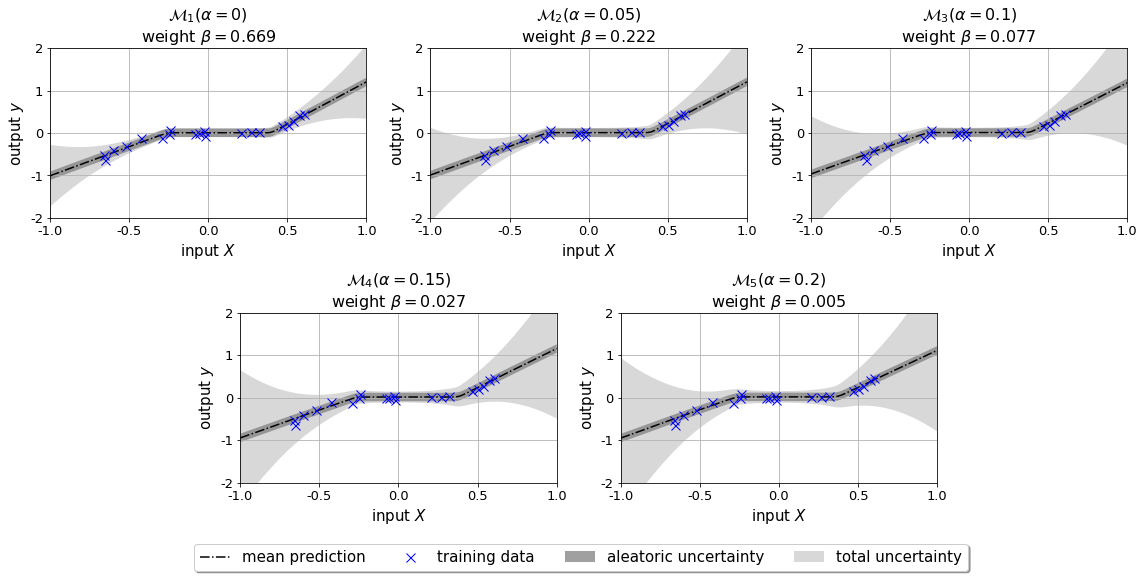

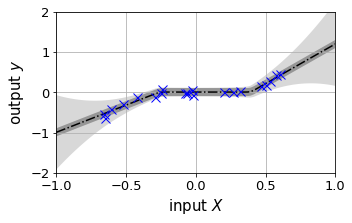

In [48]:
stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'

titles = [r'$\mathcal{}_{}(\alpha={})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list, getattr(model_aving, weights_attribute)))]
fig0 = plot_regressors_v2(regressors=model_aving.regressors, stat_to_plot=stat_to_plot, titles=titles, 
                       figsize=(16, 7.5), ns=10000)
#fig0.savefig('cubic_LOOalphaBB_all_v2.pdf', xbbox_inches = "tight")
fig0.show()

fig1 = plot_av_regressor(model_aving, stat_to_plot=stat_to_plot, figsize=(5, 3.2), ns=50000)
#fig1.savefig('cubic_LOOalphaBB_average_v2.pdf', xbbox_inches = "tight")
fig1.show()

In [16]:
model_aving_2 = ModelAveragingLOO(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict,
    alpha_list=alpha_list, random_seed_list=random_seed_list)

print(model_aving_2.weights_elpd)
print(model_aving_2.weights_modified_elpd)
print(model_aving_2.weights_elpd_bb)

Adding model with alpha=0
Adding model with alpha=0.05
Adding model with alpha=0.1
Adding model with alpha=0.15
Adding model with alpha=0.2
[0.43959739 0.37371639 0.13511265 0.04508923 0.00648434]
[0.39678951 0.39383026 0.14892896 0.05269156 0.0077597 ]


[19839, 19691, 7446, 2634, 387]
(49997, 100, 1)


/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


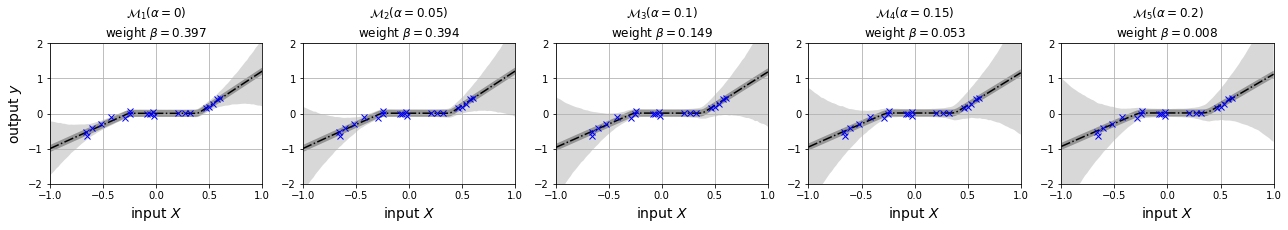

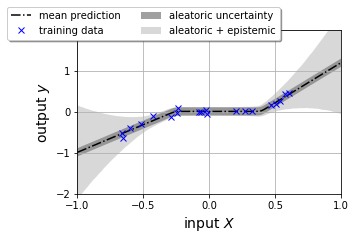

In [17]:
stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'

titles = [r'$\mathcal{}_{}(\alpha={})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list, getattr(model_aving_2, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving_2.regressors, stat_to_plot=stat_to_plot, titles=titles, 
                       figsize=(18, 3.3), ns=10000)

fig0.show()

fig1 = plot_av_regressor(model_aving_2, stat_to_plot=stat_to_plot, figsize=(5, 3.5), ns=50000)
fig1.show()

In [17]:
print(type(model_aving.regressors[0]))

<class 'tuple'>
